In [6]:
# Do a generic simulation of the FZK - House with the FZK weather data  
# weather data: src\districtgenerator\data\weather\FZK_DWD-TRY-MiddleYear_DWD.csv als Wetterdaten
# Input: C:\Users\felix\Programmieren\tecdm\src\districtgenerator\data\scenarios\FZK-Haus.csv as scenario

In [7]:
from districtgenerator import Datahandler 
import os 

In [8]:
parent_folder_path = os.path.dirname(os.getcwd())
fzk_weather_file = os.path.join(parent_folder_path, "data", "examples", "weather_data", "FZK_DWD-TRY-MiddleYear_DWD.csv")

In [9]:
fzk_generic = Datahandler(weather_file=fzk_weather_file)

In [10]:
fzk_generic.setResultPath(r'C:\Users\felix\Programmieren\tecdm\data')

In [11]:

fzk_generic.generateEnvironment()

In [12]:
fzk_generic.resultPath

'C:\\Users\\felix\\Programmieren\\tecdm\\data\\results'

In [13]:
fzk_generic.initializeBuildings(scenario_name="FZK-Haus")

In [14]:
fzk_generic.generateBuildings()

In [15]:
# set number of peoples in building 
fzk_generic.district[0]['user'].nb_occ[0] = 2
fzk_generic.generateDemands(calcUserProfiles=True, saveUserProfiles=True, 
                            savePath="fzk_generic")

Calculate demands of building SFH_1_0
C:\Users\felix\Programmieren\tecdm\data\results\results\demands\fzk_generic
Save heating profile of building SFH_1_0 in C:\Users\felix\Programmieren\tecdm\data\results\results\demands\fzk_generic
Finished generating demands!


In [16]:
fzk_generic.district[0]

{'buildingFeatures': id              0
 building      SFH
 year         2020
 retrofit        1
 area        240.0
 Name: 0, dtype: object,
 'envelope': <districtgenerator.envelope.Envelope at 0x1a93679ef20>,
 'user': <districtgenerator.users.Users at 0x1a935646c50>,
 'heatload': 8202.902376542776,
 'bivalent': 8202.902376542776,
 'heatlimit': 8202.902376542776,
 'dhwload': 4662.1,
 'unique_name': 'SFH_1_0'}

In [17]:
fzk_generic.resultPath 

'C:\\Users\\felix\\Programmieren\\tecdm\\data\\results'

In [18]:
# Now compare the results 
# Get FZK - data 


In [19]:
import numpy as np
import pandas as pd 
from lxml import etree

def extract_energy_demand_for_analysis(gml_path):
    """
    Extracts 'EnergyDemand' data along with 'energy:values' and their 'uom' from a GML file,
    converting the values into a format suitable for analysis (e.g., numpy array).

    Parameters:
    gml_path (str): Path to the GML file.

    Returns:
    pandas.DataFrame: DataFrame containing the 'EnergyDemand' data along with values and units of measure.
    """

    # Parse the GML file
    tree = etree.parse(gml_path)
    root = tree.getroot()

    # Define the namespace map to simplify finding elements
    namespaces = {k if k is not None else 'default': v for k, v in root.nsmap.items()}

    # Find all 'EnergyDemand' elements
    energy_demand_elements = tree.xpath('//energy:EnergyDemand', namespaces=namespaces)

    # Extract relevant data from these elements
    data = []
    for elem in energy_demand_elements:
        energy_demand_data = {'gml_id': elem.get('{http://www.opengis.net/gml}id')}
        for child in elem.iterdescendants():
            if child.tag.endswith('acquisitionMethod'):
                energy_demand_data['acquisition_method'] = child.text
            elif child.tag.endswith('interpolationType'):
                energy_demand_data['interpolation_type'] = child.text
            elif child.tag.endswith('source'):
                energy_demand_data['source'] = child.text
            elif child.tag.endswith('thematicDescription'):
                energy_demand_data['thematic_description'] = child.text
            elif child.tag.endswith('beginPosition'):
                energy_demand_data['begin_position'] = child.text
            elif child.tag.endswith('endPosition'):
                energy_demand_data['end_position'] = child.text
            elif child.tag.endswith('uom'):
                energy_demand_data['unit_of_measure'] = child.text
            elif child.tag.endswith('values'):
                # Splitting the values string and converting to a numpy array of floats
                values = np.array(child.text.split(), dtype=float)
                energy_demand_data['energy_values'] = values

        data.append(energy_demand_data)

    # Convert the extracted data to a pandas DataFrame
    df = pd.DataFrame(data)
    return df

# Apply the updated function to the provided GML file
energy_demand_df_for_analysis = extract_energy_demand_for_analysis(r'C:\Users\felix\Programmieren\tecdm\data\examples\gml_data\FZKHouseLoD3-ADE-results.gml')

# Display the first few rows of the DataFrame to verify the results
energy_demand_df_for_analysis.head()

,gml_id,acquisition_method,interpolation_type,source,thematic_description,begin_position,end_position,energy_values
0,GML_9e2120cd-89d5-4a65-b0dc-f6976f79df51,simulation,averageInSucceedingInterval,EnergyPlus,Heating energy,2022-01-01T00:00:00,2022-12-31T23:00:00,"[5.9217373997837095, 6.048223325349117, 5.8854..."
1,GML_fcf26a15-2992-40d8-b1bf-3d0f650c8f32,simulation,averageInSucceedingInterval,EnergyPlus,Cooling energy,2022-01-01T00:00:00,2022-12-31T23:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [20]:
heating_demand_energy_plus = energy_demand_df_for_analysis[energy_demand_df_for_analysis['thematic_description'] == 'Heating energy']["energy_values"]
# heating_demand_energy_plus = heating_demand_energy_plus.to_numpy()
heating_demand_energy_plus[0]
len(heating_demand_energy_plus[0])

8760

In [21]:
def calculate_rmse(array1, array2):
    """
    Calculate the Root Mean Square Error (RMSE) between two NumPy arrays.

    Parameters:
    array1 (numpy.ndarray): First array.
    array2 (numpy.ndarray): Second array.

    Returns:
    float: The RMSE value.
    """
    # Ensure that the input arrays are NumPy arrays
    array1 = np.array(array1)
    array2 = np.array(array2)

    # Check if the arrays have the same shape
    if array1.shape != array2.shape:
        raise ValueError("The input arrays must have the same shape.")

    # Calculate the Mean Squared Error (MSE)
    mse = np.mean((array1 - array2) ** 2)

    # Calculate the Root Mean Square Error (RMSE)
    rmse = np.sqrt(mse)

    return rmse

In [22]:
data_fzk_districtgenerator = np.loadtxt(r'C:\Users\felix\Programmieren\tecdm\src\districtgenerator\results\demands\fzk_generic\heat_SFH_1_0.csv')
data_fzk_districtgenerator
data_fzk_districtgenerator

array([3706.66, 3739.8 , 3741.43, ..., 6002.95, 6096.9 , 6253.  ])

In [23]:
calculate_rmse(heating_demand_energy_plus[0], data_fzk_districtgenerator/1000) 

0.5642458048829689

In [24]:
def calculate_mae(array1, array2):
    """
    Calculate the Mean Absolute Error (MAE) between two NumPy arrays.

    Parameters:
    array1 (numpy.ndarray): First array.
    array2 (numpy.ndarray): Second array.

    Returns:
    float: The MAE value.
    """
    # Ensure that the input arrays are NumPy arrays
    array1 = np.array(array1)
    array2 = np.array(array2)

    # Check if the arrays have the same shape
    if array1.shape != array2.shape:
        raise ValueError("The input arrays must have the same shape.")

    # Calculate the Mean Absolute Error (MAE)
    mae = np.mean(np.abs(array1 - array2))

    return mae


In [25]:
calculate_mae(heating_demand_energy_plus[0], data_fzk_districtgenerator/1000)

0.332016004874149

In [26]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime

def plot_yearly_comparison(energyplus, districtgenerator, title="Yearly Data Comparison", y_label="Power in kW"):
    """
    Plot two arrays of values against time from 00:00 on January 1st to 23:00 on December 31st.

    Parameters:
    energyplus (numpy.ndarray): Array for the first data set.
    districtgenerator (numpy.ndarray): Array for the second data set.
    title (str): Title of the plot.
    y_label (str): Label for the Y-axis.
    """
    # Generate an array of datetime objects for each hour of the year
    start_time = datetime.datetime(2024, 1, 1, 0, 0)
    x_array = np.array([start_time + datetime.timedelta(hours=i) for i in range(8760)])

    # Ensure that the input arrays are NumPy arrays
    energyplus = np.array(energyplus)
    districtgenerator = np.array(districtgenerator)

    # Check if the arrays have the correct length (8760 for each hour of the year)
    if len(energyplus) != 8760 or len(districtgenerator) != 8760:
        raise ValueError("Both arrays must have 8760 elements (one for each hour of the year).")

    plt.figure(figsize=(15, 6))
    plt.plot(x_array, energyplus, label='EnergyPlus', marker='o', markersize=2, color='blue')
    plt.plot(x_array, districtgenerator, label='DistrictGenerator', marker='x', markersize=2, color='red')
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel(y_label)

    # Format the x-axis to show dates properly
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gcf().autofmt_xdate()  # Rotate date labels for clarity

    plt.legend()
    plt.grid(True)
    plt.show()


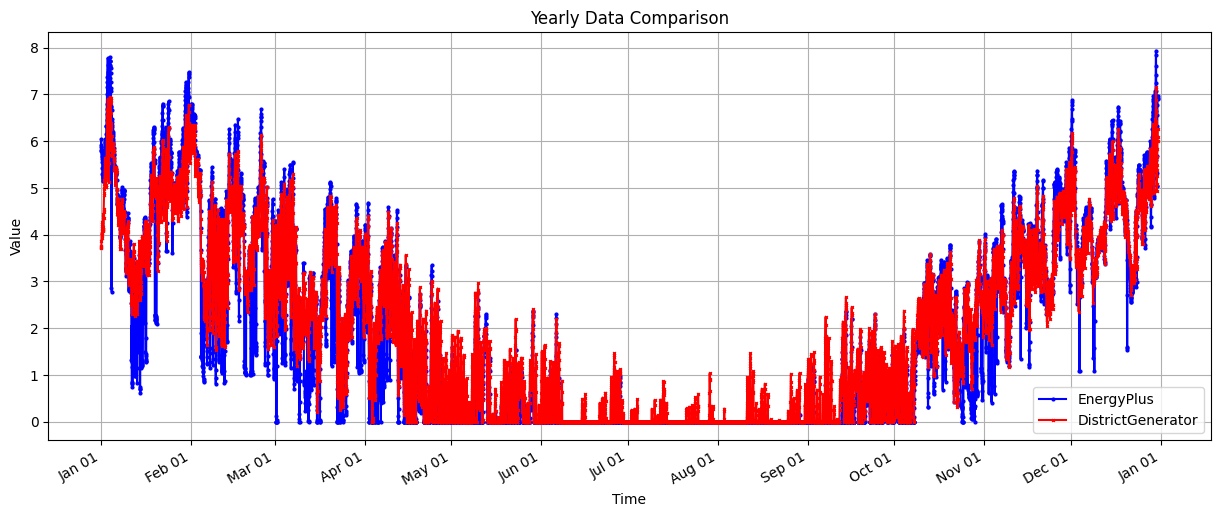

In [27]:
plot_yearly_comparison(heating_demand_energy_plus[0], data_fzk_districtgenerator/1000)